In [1]:
import torch
import numpy as np
import uncertainty_toolbox as uct
import uncertainty_toolbox.metrics as umetrics
from uncertainty_toolbox.metrics_calibration import (
    get_proportion_lists_vectorized,
)
import uncertainty_toolbox.viz as uviz
from uncertainty_toolbox.recalibration import iso_recal

from data import data_preprocess
from evaluation import metrics
from model import concrete_dropout, deep_ensemble, subnetwork

In [2]:
x_train, y_train, x_test, y_test = data_preprocess.data_preprocess('crimes')

In [3]:
deep_ensemble_model = deep_ensemble.train_model(x_train, y_train, n_epoch = 500, num_models = 5, hidden_layers = [50, 50], learning_rate = 0.001, tanh = True, exp_decay = .998)

initial loss:  -0.31644195318222046
final loss:  -5.09053373336792
initial loss:  -0.15450070798397064
final loss:  -5.1641364097595215
initial loss:  -0.22992394864559174
final loss:  -4.993998050689697
initial loss:  -0.14287470281124115
final loss:  -5.117152214050293
initial loss:  -0.1917138695716858
final loss:  -5.201437950134277


In [4]:
concrete_dropout_model = concrete_dropout.train_model(x_train, y_train, n_epoch = 200, n_features = 30, learning_rate = 0.001, tanh = True)

final loss:  -4.563517093658447


Deep ensemble test MAPE:  0.62693685
Deep ensemble test RMSE:  0.13027544
Deep ensemble test NLLK:  -1.9458694
Deep ensemble test CRPS:  tensor(0.0647)


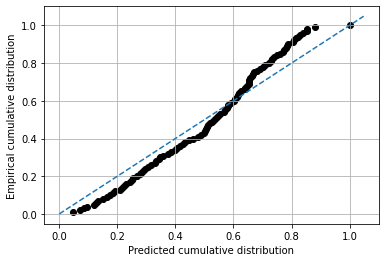

Deep ensemble test calibration error when step size is 0.001:  4.725907234755133
Deep ensemble test calibration error when step size is 0.01:  0.46402731547959475
Deep ensemble test calibration error when step size is 0.1:  0.03786828993330563


In [5]:
mean_pred, var_pred = deep_ensemble_model(x_test)
mean_pred = mean_pred.detach().numpy()
var_pred = var_pred.detach().numpy()
sd_pred = np.sqrt(var_pred)

print('Deep ensemble test MAPE: ', metrics.mape(y_test.detach().numpy(), mean_pred))
print('Deep ensemble test RMSE: ', metrics.rmse(y_test.detach().numpy(), mean_pred))
print('Deep ensemble test NLLK: ', metrics.nllk(y_test.detach().numpy(), mean_pred, var_pred))
print('Deep ensemble test CRPS: ', metrics.CRPSMetric(x = y_test.squeeze(dim = 1), loc = torch.tensor(mean_pred).squeeze(dim = 1), scale = torch.tensor(sd_pred).squeeze(dim = 1)).gaussian_crps().mean())

pcdf = metrics.pcdf(mean_pred.squeeze(1), var_pred.squeeze(1), y_test.detach().numpy().squeeze(1))
metrics.draw_pcdf(pcdf)
print('Deep ensemble test calibration error when step size is 0.001: ', metrics.calibration_error(pcdf, step = 0.001))
print('Deep ensemble test calibration error when step size is 0.01: ', metrics.calibration_error(pcdf, step = 0.01))
print('Deep ensemble test calibration error when step size is 0.1: ', metrics.calibration_error(pcdf, step = 0.1))

In [6]:
print(uct.metrics.get_all_metrics(mean_pred.squeeze(1), sd_pred.squeeze(1), y_test.detach().numpy().squeeze(1)))

 (1/n) Calculating accuracy metrics
 (2/n) Calculating average calibration metrics


 20%|████████▌                                  | 2/10 [00:00<00:00, 11.29it/s]

 (3/n) Calculating adversarial group calibration metrics
  [1/2] for mean absolute calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


 20%|████████▌                                  | 2/10 [00:00<00:00, 10.96it/s]

  [2/2] for root mean squared calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 10.14it/s]

 (4/n) Calculating sharpness metrics
 (n/n) Calculating proper scoring rule metrics
**Finished Calculating All Metrics**


===================== Accuracy Metrics =====================
  MAE           0.085
  RMSE          0.130
  MDAE          0.054
  MARPD         44.681
  R2            0.659
  Correlation   0.819
=============== Average Calibration Metrics ================
  Root-mean-squared Calibration Error   0.129
  Mean-absolute Calibration Error       0.116
  Miscalibration Area                   0.117
========== Adversarial Group Calibration Metrics ===========
  Mean-absolute Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.174
     Group Size: 0.56 -- Calibration Error: 0.131
     Group Size: 1.00 -- Calibration Error: 0.116
  Root-mean-squared Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.207
     Group Size: 0.56 -- Calibration Error: 0.153
     Group Size: 1.00 -- Calibration Error: 0.129
===============

Lims is None. Setting lims now:
min_max_true: (0.0, 1.0)
min_max_pred: (0.019198675, 0.9595497)
lims: (0.0, 1.0)
lims_ext: (-0.1, 1.1)


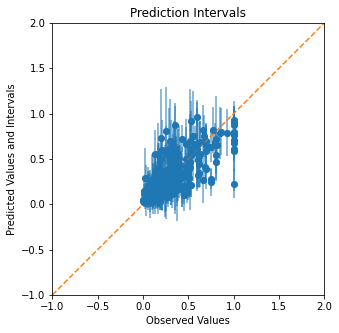

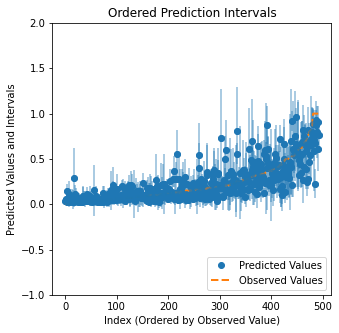

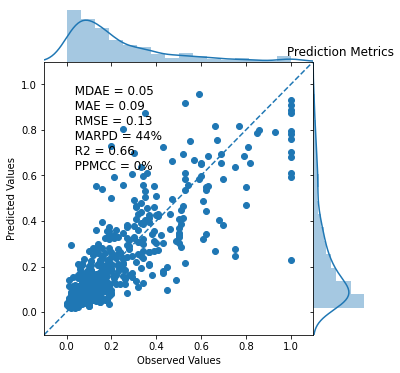

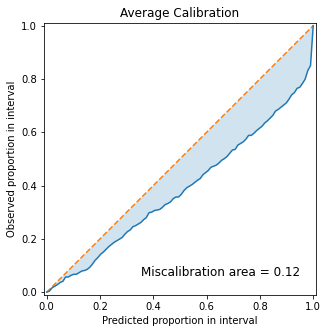

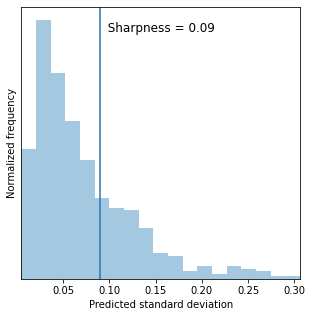

In [7]:
y = y_test.detach().numpy().squeeze(1)

uviz.plot_intervals(mean_pred.squeeze(1), sd_pred.squeeze(1), y)
uviz.plot_intervals_ordered(mean_pred.squeeze(1), sd_pred.squeeze(1), y)
uviz.plot_parity(mean_pred.squeeze(1), y)
uviz.plot_calibration(mean_pred.squeeze(1), sd_pred.squeeze(1), y)
uviz.plot_sharpness(sd_pred.squeeze(1))

Concrete dropout test MAPE:  0.7120192
Concrete dropout test RMSE:  0.1404039
Concrete dropout test NLLK:  -0.3070685
Concrete dropout test CRPS:  tensor(0.0718)


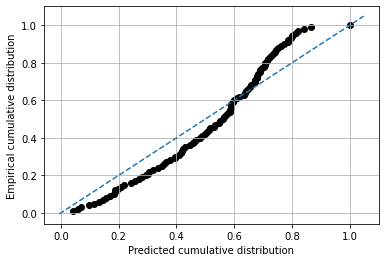

Concrete dropout test calibration error when step size is 0.001:  6.9028501475011215
Concrete dropout test calibration error when step size is 0.01:  0.6839214109089116
Concrete dropout test calibration error when step size is 0.1:  0.06060197737904703


In [8]:
mean_pred, log_var_pred, _ = concrete_dropout_model(x_test)
mean_pred = mean_pred.detach().numpy()
var_pred = np.exp(log_var_pred.detach().numpy())
sd_pred = np.sqrt(var_pred)

print('Concrete dropout test MAPE: ', metrics.mape(y_test.detach().numpy(), mean_pred))
print('Concrete dropout test RMSE: ', metrics.rmse(y_test.detach().numpy(), mean_pred))
print('Concrete dropout test NLLK: ', metrics.nllk(y_test.detach().numpy(), mean_pred, var_pred))
print('Concrete dropout test CRPS: ', metrics.CRPSMetric(x = y_test.squeeze(dim = 1), loc = torch.tensor(mean_pred).squeeze(dim = 1), scale = torch.tensor(sd_pred).squeeze(dim = 1)).gaussian_crps().mean())

pcdf = metrics.pcdf(mean_pred.squeeze(1), var_pred.squeeze(1), y_test.detach().numpy().squeeze(1))
metrics.draw_pcdf(pcdf)
print('Concrete dropout test calibration error when step size is 0.001: ', metrics.calibration_error(pcdf, step = 0.001))
print('Concrete dropout test calibration error when step size is 0.01: ', metrics.calibration_error(pcdf, step = 0.01))
print('Concrete dropout test calibration error when step size is 0.1: ', metrics.calibration_error(pcdf, step = 0.1))

In [9]:
print(uct.metrics.get_all_metrics(mean_pred.squeeze(1), sd_pred.squeeze(1), y_test.detach().numpy().squeeze(1)))

 (1/n) Calculating accuracy metrics
 (2/n) Calculating average calibration metrics


 20%|████████▌                                  | 2/10 [00:00<00:00, 10.72it/s]

 (3/n) Calculating adversarial group calibration metrics
  [1/2] for mean absolute calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


 20%|████████▌                                  | 2/10 [00:00<00:00, 10.39it/s]

  [2/2] for root mean squared calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████████████████████████████████████| 10/10 [00:01<00:00,  9.67it/s]

 (4/n) Calculating sharpness metrics
 (n/n) Calculating proper scoring rule metrics
**Finished Calculating All Metrics**


===================== Accuracy Metrics =====================
  MAE           0.094
  RMSE          0.140
  MDAE          0.059
  MARPD         48.972
  R2            0.604
  Correlation   0.793
=============== Average Calibration Metrics ================
  Root-mean-squared Calibration Error   0.149
  Mean-absolute Calibration Error       0.134
  Miscalibration Area                   0.135
========== Adversarial Group Calibration Metrics ===========
  Mean-absolute Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.191
     Group Size: 0.56 -- Calibration Error: 0.151
     Group Size: 1.00 -- Calibration Error: 0.134
  Root-mean-squared Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.209
     Group Size: 0.56 -- Calibration Error: 0.173
     Group Size: 1.00 -- Calibration Error: 0.149
===============

Lims is None. Setting lims now:
min_max_true: (0.0, 1.0)
min_max_pred: (0.018170148, 0.9730469)
lims: (0.0, 1.0)
lims_ext: (-0.1, 1.1)


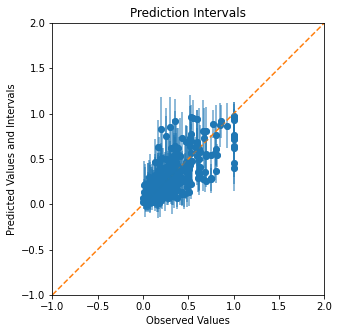

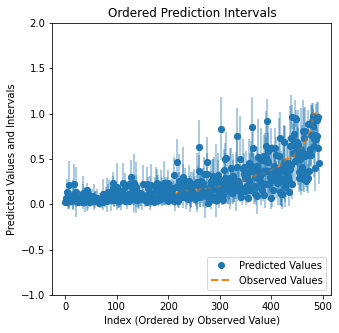

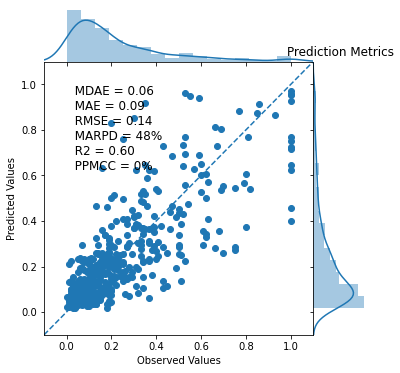

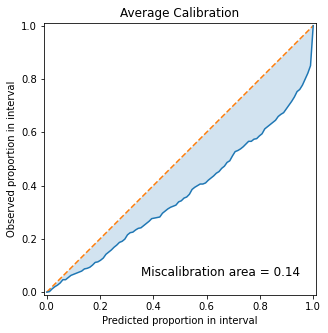

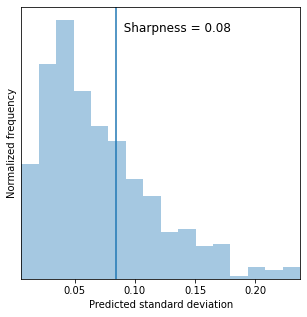

In [10]:
y = y_test.detach().numpy().squeeze(1)

uviz.plot_intervals(mean_pred.squeeze(1), sd_pred.squeeze(1), y)
uviz.plot_intervals_ordered(mean_pred.squeeze(1), sd_pred.squeeze(1), y)
uviz.plot_parity(mean_pred.squeeze(1), y)
uviz.plot_calibration(mean_pred.squeeze(1), sd_pred.squeeze(1), y)
uviz.plot_sharpness(sd_pred.squeeze(1))

In [20]:
subnetwork_model = subnetwork.train_model(x_train, y_train, n_epoch = 500, num_models = 5, hidden_layers = [50, 50], learning_rate = 0.001, tanh = True, exp_decay = .998)

initial loss:  -0.21988604962825775
final loss:  -3.7186450958251953


Subnetwork test MAPE:  0.7327752
Subnetwork test RMSE:  0.12937227
Subnetwork test NLLK:  -3.4713638
Subnetwork test CRPS:  tensor(0.0644)


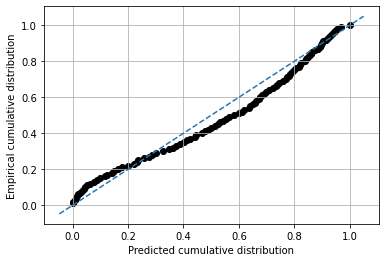

Subnetwork test calibration error when step size is 0.001:  2.7674217770902154
Subnetwork test calibration error when step size is 0.01:  0.2770577743582569
Subnetwork test calibration error when step size is 0.1:  0.029084053009886885


In [22]:
mean_pred, var_pred = subnetwork.test_model(subnetwork_model, x_test)
mean_pred = mean_pred.detach().numpy()
var_pred = var_pred.detach().numpy()
sd_pred = np.sqrt(var_pred)

print('Subnetwork test MAPE: ', metrics.mape(y_test.detach().numpy(), mean_pred))
print('Subnetwork test RMSE: ', metrics.rmse(y_test.detach().numpy(), mean_pred))
print('Subnetwork test NLLK: ', metrics.nllk(y_test.detach().numpy(), mean_pred, var_pred))
print('Subnetwork test CRPS: ', metrics.CRPSMetric(x = y_test.squeeze(dim = 1), loc = torch.tensor(mean_pred).squeeze(dim = 1), scale = torch.tensor(sd_pred).squeeze(dim = 1)).gaussian_crps().mean())

pcdf = metrics.pcdf(mean_pred.squeeze(1), var_pred.squeeze(1), y_test.detach().numpy().squeeze(1))
metrics.draw_pcdf(pcdf)
print('Subnetwork test calibration error when step size is 0.001: ', metrics.calibration_error(pcdf, step = 0.001))
print('Subnetwork test calibration error when step size is 0.01: ', metrics.calibration_error(pcdf, step = 0.01))
print('Subnetwork test calibration error when step size is 0.1: ', metrics.calibration_error(pcdf, step = 0.1))

In [23]:
print(uct.metrics.get_all_metrics(mean_pred.squeeze(1), sd_pred.squeeze(1), y_test.detach().numpy().squeeze(1)))

 (1/n) Calculating accuracy metrics
 (2/n) Calculating average calibration metrics


 20%|████████▌                                  | 2/10 [00:00<00:00, 10.99it/s]

 (3/n) Calculating adversarial group calibration metrics
  [1/2] for mean absolute calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


 20%|████████▌                                  | 2/10 [00:00<00:00, 10.90it/s]

  [2/2] for root mean squared calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████████████████████████████████████| 10/10 [00:01<00:00,  9.88it/s]

 (4/n) Calculating sharpness metrics
 (n/n) Calculating proper scoring rule metrics
**Finished Calculating All Metrics**


===================== Accuracy Metrics =====================
  MAE           0.088
  RMSE          0.129
  MDAE          0.056
  MARPD         45.989
  R2            0.664
  Correlation   0.816
=============== Average Calibration Metrics ================
  Root-mean-squared Calibration Error   0.043
  Mean-absolute Calibration Error       0.036
  Miscalibration Area                   0.037
========== Adversarial Group Calibration Metrics ===========
  Mean-absolute Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.098
     Group Size: 0.56 -- Calibration Error: 0.050
     Group Size: 1.00 -- Calibration Error: 0.036
  Root-mean-squared Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.102
     Group Size: 0.56 -- Calibration Error: 0.063
     Group Size: 1.00 -- Calibration Error: 0.043
===============

Lims is None. Setting lims now:
min_max_true: (0.0, 1.0)
min_max_pred: (0.02235884, 0.78872836)
lims: (0.0, 1.0)
lims_ext: (-0.1, 1.1)


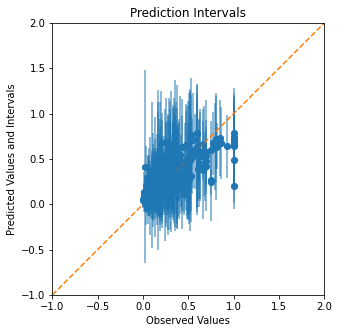

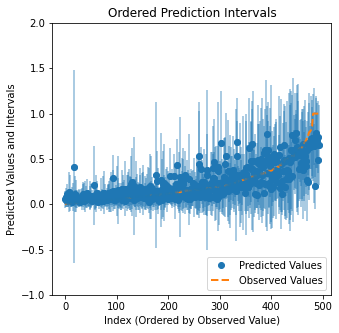

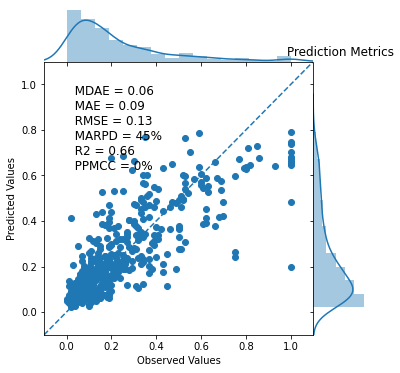

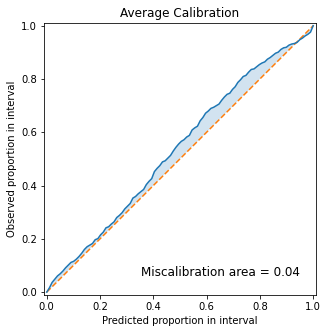

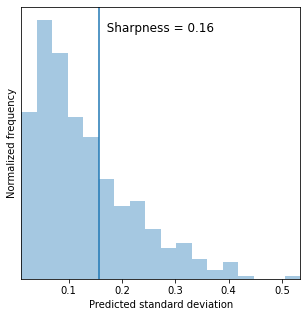

In [24]:
y = y_test.detach().numpy().squeeze(1)

uviz.plot_intervals(mean_pred.squeeze(1), sd_pred.squeeze(1), y)
uviz.plot_intervals_ordered(mean_pred.squeeze(1), sd_pred.squeeze(1), y)
uviz.plot_parity(mean_pred.squeeze(1), y)
uviz.plot_calibration(mean_pred.squeeze(1), sd_pred.squeeze(1), y)
uviz.plot_sharpness(sd_pred.squeeze(1))